In [2]:
using PyCall
using Plots
using Dates
using Indicators
using Distributions
using DataFrames
using .Threads
using Statistics
using GLM

In [18]:
include("Labeling.jl")
include("hpc.jl")
include("MixtureModel.jl")
include("BetSizing.jl")

limitPrice (generic function with 1 method)

In [11]:
py"""
import yfinance
import datetime as dt
def get_data():
  enddate = dt.datetime.strptime("2021-01-01", "%Y-%m-%d").date()
  startdate = enddate - dt.timedelta(days=360*2) # for 5 years

  data = yfinance.download(tickers="AAPL", period="700d", interval="1h")
  return data
"""

In [12]:
df = py"get_data"();

[*********************100%***********************]  1 of 1 completed

In [13]:
py"""
import pandas as pd
import numpy as np

def get_ohlcv(df_group):
    ohlc = df_group['Close'].ohlc()
    ohlc['volume'] = df_group['Volume'].sum()
    return ohlc

def get_time_bar(df, freq="5Min"):
    df_group = df.groupby(pd.Grouper(freq=freq))
    
    ohlcv = get_ohlcv(df_group).dropna()
    return ohlcv.index , ohlcv.to_numpy()
"""

In [14]:
py"""
def reset_data_time(data):
  df  = data.copy()
  df.set_index(df.index.strftime("%Y-%m-%d"))
  return df
"""

In [15]:
indexs ,ohlcv = py"get_time_bar"(df, freq="1B")
index = indexs.strftime("%Y-%m-%d");

In [16]:
data = DataFrame(Dates = Date.(index,dateformat"y-m-d"),open = ohlcv[:,1] , high = ohlcv[:,2] , low = ohlcv[:,3] , close = ohlcv[:,4] , volume = ohlcv[:,5]);

In [26]:
close = select(data,["Dates" , "close"])
rets,std = dailyVol(close,32);

In [30]:
x=rets[!,:x1]
scatter(x,rets[!,:x2] , label = "returns", background = :transparent)
plot!(x,std[!,:x2] , label = "+std", background = :transparent)
plot!(x,-1*std[!,:x2] , label = "-std", background = :transparent)


In [32]:
savefig("Figs/return_std.png")

In [11]:
numDays = 21
tEvents = events(close, 2);

In [12]:
t1 = verticalbarrier(close,tEvents,numDays);

In [13]:
events_ = events(close, tEvents, 1, std, 0.0; timestamp = t1.x2)

,date,timestamp,target
,Any,Date,Any
1,2019-12-06,2019-12-16,0.0222091
2,2019-12-13,2019-12-16,0.0164962
3,2019-12-23,2019-12-26,0.0129373
4,2019-12-31,2020-01-02,0.0110751
5,2020-01-08,2020-01-09,0.00983509
6,2020-01-13,2020-01-14,0.0116095
7,2020-01-27,2020-01-28,0.0158634
8,2020-01-28,2020-01-29,0.0154711
9,2020-01-31,2020-02-04,0.0225548


In [14]:
out = label(events_,close)

,Dates,ret,bin
,Any,Float64,Float64
1,2019-12-06,0.0338381,1.0
2,2019-12-13,0.0167114,1.0
3,2019-12-23,0.0209177,1.0
4,2019-12-31,0.0242977,1.0
5,2020-01-08,0.0216746,1.0
6,2020-01-13,-0.0135029,-1.0
7,2020-01-27,0.0285159,1.0
8,2020-01-28,0.0207703,1.0
9,2020-01-31,0.0306085,1.0


In [15]:
X = copy(data)
features = DataFrame(Dates=Date.(index,dateformat"y-m-d"))

using Indicators

features.SMA_5 = sma(values(X[!,"close"]), n=5)
features.SMA_15 = sma(values(X[!,"close"]), n=15)
features.volume_ratio = sma(values(X[!,"volume"]), n=5)./sma(values(X[!,"volume"]), n=15);
features.RSI_15 = rsi(values(X[!,"close"]), n=15, ma=sma)
features.RSI_5 = rsi(values(X[!,"close"]), n=5, ma=sma);
features.upperband = Indicators.bbands(values(X[!,"close"]), n=15)[:,3] 
features.lowerband = Indicators.bbands(values(X[!,"close"]), n=15)[:,1];
features.MACD = Indicators.macd(values(X[!,"close"]), nfast=5, nslow=15)[:,1];
hlc = [values(X.high) values(X.low) values(X.close)]
features.Stochastic_5 = stoch(hlc, nK=5)[:,1]
features.Stochastic_15 = Indicators.stoch(hlc, nK=15)[:,1];

In [16]:
features = filter(row -> row[:Dates] in out.Dates, features)
features.label = Int.((out.bin .+ 1) /2)
features = filter(row -> all(x -> !(x isa Number && isnan(x)), row), features)

,Dates,SMA_5,SMA_15,volume_ratio,RSI_15,RSI_5,upperband,lowerband
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019-12-23,70.161,68.227,0.977424,75.383,80.7175,71.9854,64.4686
2,2019-12-31,72.4597,70.3059,0.988727,95.321,99.1708,74.1678,66.444
3,2020-01-08,74.957,72.5259,1.1594,82.8152,75.2869,76.7545,68.2973
4,2020-01-13,76.921,74.1434,1.12988,88.4304,92.5284,79.4598,68.827
5,2020-01-27,79.041,77.9535,0.93009,61.4668,18.0264,81.3888,74.5182
6,2020-01-28,79.1015,78.2532,0.982573,65.8108,52.7639,81.3292,75.1771
7,2020-01-31,79.2168,79.0289,1.22869,49.771,38.7576,81.416,76.6419
8,2020-02-04,79.2583,79.0323,1.23147,51.3674,51.6944,81.5257,76.5389
9,2020-02-12,80.68,79.7446,0.770811,56.2715,64.1776,82.6564,76.8328


In [17]:
using GLM
fm = @formula(label ~ SMA_5 +SMA_15 + volume_ratio + RSI_5 + upperband + Stochastic_5 + Stochastic_15)
logit = glm(fm, features, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

label ~ 1 + SMA_5 + SMA_15 + volume_ratio + RSI_5 + upperband + Stochastic_5 + Stochastic_15

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)     1.6167      0.643961     2.51    0.0121   0.354559    2.87884
SMA_5          -0.0595407   0.0379544   -1.57    0.1167  -0.13393     0.0148485
SMA_15          0.0712928   0.0450478    1.58    0.1135  -0.0169993   0.159585
volume_ratio   -0.712298    0.415649    -1.71    0.0866  -1.52695     0.102359
RSI_5           0.00261526  0.00572597   0.46    0.6479  -0.00860744  0.013838
upperband      -0.0197019   0.0238044   

In [18]:
prediction = GLM.predict(logit, features)
prediction = [x<0.5 ? -1 : 1 for x in prediction];
function confusion_matrix(A, B)
    actualPositives = sum(A .== 1)
    actualNegatives = sum(A .== -1)
    println("***************")
    print("Actual Positives: ")
    println(actualPositives)
    print("Actual Negatives: ")
    println(actualNegatives)
    println()
    truePositives = sum( (A .== B) .& (A .== 1) )
    print("True Positives: ")
    println(truePositives)
    trueNegatives = sum( (A .== B) .& (A .== -1) )
    print("True Negatives: ")
    println(trueNegatives)
    falsePositives = sum( .!(A .== B) .& (A .== -1) )
    print("False Positives: ")
    println(falsePositives)
    falseNegatives = sum( .!(A .== B) .& (A .== 1) )
    print("False Negatives: ")
    println(falseNegatives)
    println("***************")
    return [actualPositives, actualNegatives, truePositives, trueNegatives, falsePositives, falseNegatives]
end

confusion_matrix(2*features.label .- 1, prediction);

***************
Actual Positives: 175
Actual Negatives: 143

True Positives: 124
True Negatives: 73
False Positives: 70
False Negatives: 51
***************


In [19]:
features.predict =   prediction .+ 1 
features.meta_label  =  features.predict .!= features.label

fm = @formula(meta_label ~ SMA_5 +SMA_15 + volume_ratio + RSI_5 + upperband + upperband + Stochastic_5 + Stochastic_15 + predict)
logit = glm(fm, features, Binomial(), ProbitLink())
 


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

meta_label ~ 1 + SMA_5 + SMA_15 + volume_ratio + RSI_5 + upperband + Stochastic_5 + Stochastic_15 + predict

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                     Coef.   Std. Error      z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)     3.07578      1.89754      1.62    0.1050   -0.643333     6.7949
SMA_5          -0.144545     0.0708004   -2.04    0.0412   -0.283311    -0.00577886
SMA_15          0.0582085    0.0893386    0.65    0.5147   -0.116892     0.233309
volume_ratio   -1.29619      0.764809    -1.69    0.0901   -2.79519      0.202804
RSI_5           0.00272768   0.00952071   0.29    0.7745   -0.0159326    0.0213879


In [20]:
probability = GLM.predict(logit, features)
prediction = [x<0.5 ? -1 : 1 for x in probability]

confusion_matrix(2*features.meta_label .- 1, prediction);

***************
Actual Positives: 245
Actual Negatives: 73

True Positives: 211
True Negatives: 60
False Positives: 13
False Negatives: 34
***************


In [21]:
estimationResult = DataFrame(Dates = features.Dates , probability =probability )

,Dates,probability
,Date,Float64?
1,2019-12-23,1.0
2,2019-12-31,1.0
3,2020-01-08,1.0
4,2020-01-13,1.0
5,2020-01-27,1.0
6,2020-01-28,1.0
7,2020-01-31,1.0
8,2020-02-04,1.0
9,2020-02-12,1.0


In [24]:
Signals  = generateSignal(events_ , 0.1 , estimationResult , out , 2 )

,Dates,budgeting,gausian,probability
,Any,Float64,Float64,Float64
1,2019-12-23,0.2,0.3,1.0
2,2019-12-31,0.2,0.3,1.0
3,2020-01-08,0.2,0.3,1.0
4,2020-01-13,-0.2,-0.3,1.0
5,2020-01-27,0.2,0.3,1.0
6,2020-01-28,0.2,0.3,1.0
7,2020-01-31,0.2,0.3,1.0
8,2020-02-04,0.2,0.3,1.0
9,2020-02-12,-0.2,-0.3,1.0


In [25]:
out = filter(row -> row[:Dates] in Signals.Dates, out)


,Dates,ret,bin
,Any,Float64,Float64
1,2019-12-23,0.0209177,1.0
2,2019-12-31,0.0242977,1.0
3,2020-01-08,0.0216746,1.0
4,2020-01-13,-0.0135029,-1.0
5,2020-01-27,0.0285159,1.0
6,2020-01-28,0.0207703,1.0
7,2020-01-31,0.0306085,1.0
8,2020-02-04,0.0261558,1.0
9,2020-02-12,-0.0250306,-1.0


In [26]:
cum_rets = DataFrame(Dates=Signals.Dates)

returns = Signals.gausian .* out.ret
cum_rets.gaussian = (cumprod(returns .+ 1)) .- 1

returns = Signals.budgeting .* out.ret
cum_rets.budgeting = (cumprod(returns .+ 1)) .- 1

returns = Signals.probability .* out.ret
cum_rets.probability = (cumprod(returns .+ 1)) .- 1;

cum_rets.buyandhold  =  (cumprod(out.ret .+ 1)) .- 1;

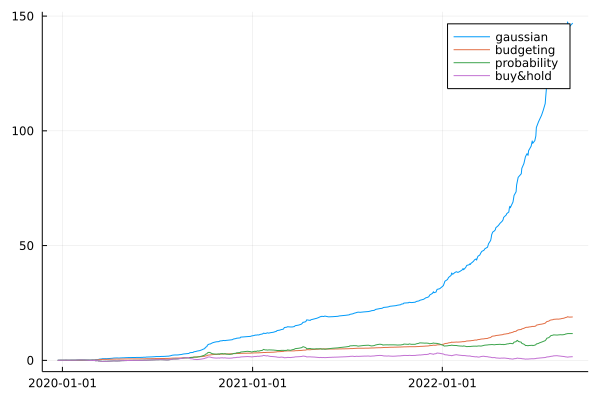

In [27]:
#!transparent
plot(cum_rets.Dates ,cum_rets.gaussian , label = "gaussian")
plot!(cum_rets.Dates ,cum_rets.budgeting , label = "budgeting")
plot!(cum_rets.Dates ,cum_rets.probability , label = "probability")
plot!(cum_rets.Dates ,cum_rets.buyandhold , label = "buy&hold")